Tensorflow version: 1.13.1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of samples: 3670
Number of training examples:   3000
Number of test examples:       300
Number of validation examples: 300


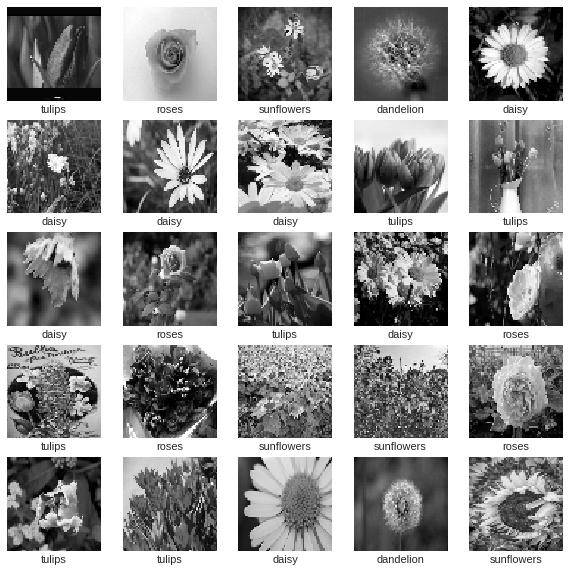

initializing the model
training the model
 28/100 [=======>......................] - ETA: 1:48 - loss: 1.6346 - acc: 0.2000

In [0]:
%matplotlib inline

# Load the Drive helper and mount
from google.colab import drive

# for tensorboard log folder name
from time import time

# dealing with directories
import os                  

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print("Tensorflow version: {}".format(tf.__version__))

#------------------------------------------------------------------------------
# global constants
#------------------------------------------------------------------------------
LOAD_MODEL = False
TRAIN_MODEL = True
FOLDER_PREFIX = '/content/drive/My Drive/Colab Notebooks/flowers_classification'
MODEL_VARIANT_NAME = 'conv1'
MODEL_NAME = '{}{}'.format(
    FOLDER_PREFIX, '/flowers_classification-{}.h5'.format(MODEL_VARIANT_NAME))
TRAIN_BATCH_SIZE = 30
NUM_TRAIN_EXAMPLES = 3000
NUM_TEST_EXAMPLES = 300
NUM_VALIDATION_EXAMPLES = 300

#------------------------------------------------------------------------------
# define functions
#------------------------------------------------------------------------------
def normalize(image, label):
    resized_image = tf.image.resize_images(image, (64, 64))
    grayscale_image = tf.image.rgb_to_grayscale(resized_image)
    normalized_grayscale_image = tf.cast(grayscale_image, tf.float32)
    normalized_grayscale_image /= 255
    # without this   1 - image   addition the images would be inverted
    normalized_grayscale_image = 1 - normalized_grayscale_image
    return normalized_grayscale_image, label
#------------------------------------------------------------------------------


# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()  

# This will prompt for authorization.
drive.mount('/content/drive')

dataset, metadata = tfds.load('tf_flowers', as_supervised=True, with_info=True)
print('Classes: {}'.format(metadata.features['label'].names))
print('Number of samples: {}'.format(metadata.splits['train'].num_examples))

all_data = dataset['train']
train_data = all_data.take(NUM_TRAIN_EXAMPLES)
validation_data = all_data.skip(NUM_TRAIN_EXAMPLES)
test_data = validation_data.skip(NUM_VALIDATION_EXAMPLES)
validation_data = validation_data.take(NUM_VALIDATION_EXAMPLES)
test_data = test_data.take(NUM_TEST_EXAMPLES)

print("Number of training examples:   {}".format(NUM_TRAIN_EXAMPLES))
print("Number of test examples:       {}".format(NUM_TEST_EXAMPLES))
print("Number of validation examples: {}".format(NUM_VALIDATION_EXAMPLES))



train_data = train_data.map(normalize)
validation_data = validation_data.map(normalize)
test_data = test_data.map(normalize)


plt.figure(figsize=(10,10))
i = 0
for (image, label) in train_data.take(25):
    image = image.numpy().reshape((64,64))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(metadata.features['label'].names[label])
    i += 1
plt.show()


# load model or create a new model
if LOAD_MODEL == True:
    print('trying to load the model')
    if os.path.exists(MODEL_NAME):
        model = tf.keras.models.load_model(MODEL_NAME)
        print('model loaded!')
    else:
        print('loading the model failed: file does not exist')

else:
    print('initializing the model')
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), 
                               padding='same', 
                               activation=tf.nn.relu, 
                               input_shape=(64, 64, 1)),

        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        
        tf.keras.layers.Conv2D(64, (5, 5), 
                               padding='same',
                               activation=tf.nn.relu),
        
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        
        tf.keras.layers.Conv2D(128, (5, 5), 
                               padding='same', 
                               activation=tf.nn.relu),
        
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        
        tf.keras.layers.Conv2D(256, (5, 5), 
                               padding='same', 
                               activation=tf.nn.relu),
        
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        
        tf.keras.layers.Conv2D(512, (5, 5), 
                               padding='same', 
                               activation=tf.nn.relu),
        
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(5,  activation=tf.nn.softmax)
    ])
    
    model.compile(optimizer='adam', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    #model.save(MODEL_NAME, overwrite=True)

    
if TRAIN_MODEL == True:
    print('training the model')

    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='{}{}'.format(FOLDER_PREFIX, '/logs/{}'.format(time())))

    train_data = train_data.repeat().shuffle(
        NUM_TRAIN_EXAMPLES).batch(
        TRAIN_BATCH_SIZE)

    test_data = test_data.batch(TRAIN_BATCH_SIZE)

    model.fit(train_data, 
              epochs=1, 
              steps_per_epoch=math.ceil(NUM_TRAIN_EXAMPLES/TRAIN_BATCH_SIZE),
              callbacks=[tensorboard])

    model.save(MODEL_NAME, overwrite=True)
